<a href="https://colab.research.google.com/github/mlfa19/assignments/blob/master/Module%201/m1_project/Examples/Visualizing_Your_Network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Visualizing Your Network

In this example we'll show a few ways in which you can visualize what your network is doing.  We'll be using the Caltech 256 dataset for this work.

In [1]:
import gdown
gdown.download('https://drive.google.com/uc?authuser=0&id=16ieLmAEV6Xn4Iw0GwYGQJkeXenEaKcz-&export=download',
               'caltech.hdf5',
               quiet=False)

Downloading...
From: https://drive.google.com/uc?authuser=0&id=16ieLmAEV6Xn4Iw0GwYGQJkeXenEaKcz-&export=download
To: /content/caltech.hdf5
6.02GB [00:28, 213MB/s]


'caltech.hdf5'

In [0]:
from torchvision.datasets import VisionDataset
import h5py

class H5Dataset(VisionDataset):
    def __init__(self, h5_path, root, transform=None, target_transform=None):
        super(H5Dataset, self).__init__(root, transform=transform, target_transform=target_transform)
        self.h5_file = h5py.File(h5_path, 'r', libver='latest', swmr=True)
        self.target_cache = []
        for i in range(len(self)):
            self.target_cache.append(self.h5_file['targets'][i])

    def __getitem__(self, index):
        return torch.FloatTensor(self.h5_file['data'][index]), self.target_cache[index]

    def __len__(self):
        return len(self.h5_file['data'])

    def close_dataset(self):
        self.h5_file.close()

cal_tech = H5Dataset('caltech.hdf5', '.')

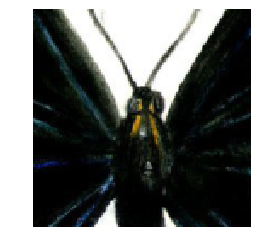

In [17]:
import matplotlib.pyplot as plt
def show_image(img_tensor):
    # need to reorder the tensor dimensions to work properly with imshow
    plt.imshow(img_tensor.transpose(0,2).transpose(0,1))
    plt.axis('off')
    plt.show()

im, target = cal_tech[3000]
show_image(im.to('cpu'))

In [0]:
from torch.utils.data.sampler import SubsetRandomSampler
import torch
import numpy as np

batch_size = 32
learning_rate = 1e-3
n_epochs = 8
image_dims = 3, 128, 128

In [0]:
import torch.optim as optim
import torch.nn as nn

class myCNN(nn.Module):
    def __init__(self):
        super(myCNN, self).__init__()
        class_len = 257
        self.activation_func = torch.nn.ReLU()
        self.sigmoid = torch.nn.Sigmoid()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.pool5 = nn.MaxPool2d(kernel_size=5, stride=5, padding=0)
        self.fc1_size = 512
        self.fc2_size = class_len
        # Convolutional Layers
        self.conv1 = nn.Conv2d(image_dims[0], 32, kernel_size=3,
                  stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3,
          stride=1, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3,
          stride=1, padding=1)
        self.conv4 = nn.Conv2d(128, 128, kernel_size=3,
          stride=1, padding=1)
        self.conv5 = nn.Conv2d(128, 128, kernel_size=3,
          stride=1, padding=1)
        self.maxpool_output_size = int(128 * (image_dims[1] / 32) * (image_dims[2] / 32))

        # Fully Connected Layers
        self.fc1 = nn.Linear(self.maxpool_output_size, self.fc1_size)
        self.fc2 = nn.Linear(self.fc1_size, self.fc2_size)
        
    def forward(self, x):
        # Convolutional Layers
        x = self.activation_func(self.pool2(self.conv1(x)))
        x = self.activation_func(self.pool2(self.conv2(x)))
        x = self.activation_func(self.pool2(self.conv3(x)))
        x = self.activation_func(self.pool2(self.conv4(x)))
        x = self.activation_func(self.pool2(self.conv5(x)))
        # Fully Connected Layers
        x = x.view(-1, self.maxpool_output_size)
        x = self.fc1(x)
        x = self.activation_func(x)
        x = self.fc2(x)
        return x

    def get_loss(self, learning_rate):
      # Loss function, we'll use BCE or Binary CrossEntropy that does not assume one class fer example
      # https://pytorch.org/docs/stable/nn.html
      loss = nn.CrossEntropyLoss()
      # Optimizer, self.parameters() returns all the Pytorch operations that are attributes of the class
      optimizer = optim.Adam(self.parameters(), lr=learning_rate)
      #optimizer = optim.SGD(self.parameters(), lr=learning_rate, momentum=0.9, weight_decay=10**-5, nesterov=True)
      return loss, optimizer

In [0]:
net = myCNN()
loss, optimizer = net.get_loss(learning_rate)

# Define some parameters to keep track of metrics
print_every = 20
test_every = 500

In [0]:
from torch.autograd import Variable
import time

def test_loss(run_idx):
    # do a pass on the test set
    total_test_loss = 0
    idx = 0
    for inputs, labels in test_loader:

        # Wrap tensors in Variables
        inputs, labels = Variable(inputs).to(device), Variable(labels).to(device)

        # Forward pass
        test_outputs = net(inputs)
        test_loss_size = loss(test_outputs, labels)
        total_test_loss += test_loss_size.data.item()
        idx += 1
    test_loss_hist.append(total_test_loss / (idx+1))
    test_hist_x.append(run_idx)
    print("Validation loss = {:.4f}".format(
        total_test_loss / (idx+1)))
idx = 0
train_hist_x = []
train_loss_hist = []
test_hist_x = []
test_loss_hist = []

n_train = 20000
indices = torch.randperm(len(cal_tech))

train_idx, test_idx = indices[:n_train], indices[n_train:]
train_sampler = SubsetRandomSampler(train_idx)
test_sampler = SubsetRandomSampler(test_idx)

# Get our data into the mini batch size that we defined
train_loader = torch.utils.data.DataLoader(cal_tech, batch_size=batch_size,
                                        sampler=train_sampler, num_workers=2)


test_loader = torch.utils.data.DataLoader(cal_tech, batch_size=batch_size,
                                        sampler=test_sampler, num_workers=2)


device = 'cuda'
net.to(device)
training_start_time = time.time()
for epoch in range(n_epochs):
    running_loss = 0.0
    start_time = time.time()

    for i, data in enumerate(train_loader, 0):
        # Get inputs in right form
        inputs, labels = data
        inputs, labels = Variable(inputs).to(device), Variable(labels).to(device)
        
        # In Pytorch, We need to always remember to set the optimizer gradients to 0 before we recompute the new gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = net(inputs)
        # Compute the loss and find the loss with respect to each parameter of the model
        loss_size = loss(outputs, labels)
        loss_size.backward()
        
        # Change each parameter with respect to the recently computed loss.
        optimizer.step()

        # Update statistics
        running_loss += loss_size.data.item()
        
        # Print every 20th batch of an epoch
        if (i % print_every) == print_every-1:
            print("Epoch {}, Iteration {}\t train_loss: {:.4f} took: {:.4f}s".format(
                epoch + 1, i+1,running_loss / print_every, time.time() - start_time))
            # Reset running loss and time
            train_loss_hist.append(running_loss / print_every)
            train_hist_x.append(idx)
            running_loss = 0.0
            start_time = time.time()
        # Check test set every nth batch
        if (i % test_every) == test_every -1:
            test_loss(idx)
            idx += 1

print("Training finished, took {:.2f}s".format(
    time.time() - training_start_time))

Epoch 1, Iteration 20	 train_loss: 5.5341 took: 2.2668s
Epoch 1, Iteration 40	 train_loss: 5.5170 took: 1.6535s
Epoch 1, Iteration 60	 train_loss: 5.5045 took: 1.5159s
Epoch 1, Iteration 80	 train_loss: 5.4775 took: 1.5790s
Epoch 1, Iteration 100	 train_loss: 5.4132 took: 1.5610s
Epoch 1, Iteration 120	 train_loss: 5.3872 took: 1.5858s
Epoch 1, Iteration 140	 train_loss: 5.3665 took: 1.4544s
Epoch 1, Iteration 160	 train_loss: 5.4010 took: 1.5543s
Epoch 1, Iteration 180	 train_loss: 5.4181 took: 1.5525s
Epoch 1, Iteration 200	 train_loss: 5.4346 took: 1.5781s
Epoch 1, Iteration 220	 train_loss: 5.4591 took: 1.5705s
Epoch 1, Iteration 240	 train_loss: 5.3365 took: 1.5885s
Epoch 1, Iteration 260	 train_loss: 5.3489 took: 1.5711s
Epoch 1, Iteration 280	 train_loss: 5.3977 took: 1.5751s
Epoch 1, Iteration 300	 train_loss: 5.4058 took: 1.6120s
Epoch 1, Iteration 320	 train_loss: 5.3924 took: 1.5381s
Epoch 1, Iteration 340	 train_loss: 5.3356 took: 1.4564s
Epoch 1, Iteration 360	 train_loss:

047.computer-mouse


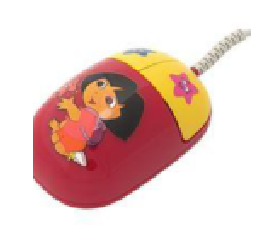

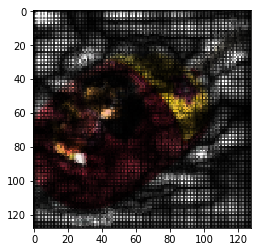

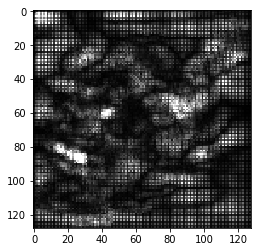

In [0]:
im, target = cal_tech[test_idx[1]]
print(cal_tech.classes[target])
prep_img = im.to(device)
show_image(prep_img.to('cpu'))
prep_img_unsqueeze = prep_img.unsqueeze(0)
input_img = Variable(prep_img_unsqueeze, requires_grad=True).to(device)
input_img.register_hook(set_gradient_hook)
model_output = net(input_img)
one_hot_output = torch.FloatTensor(1, model_output.size()[-1]).zero_()
one_hot_output[0][target] = 1
model_output.backward(gradient=one_hot_output.to(device))
grad = np.abs(input_gradients.cpu().numpy()).squeeze()
# Normalize Heatmap
grayscale_im = np.sum(grad, axis=0)
im_max = np.percentile(grayscale_im, 99)
im_min = np.min(grayscale_im)
grayscale_im = (np.clip((grayscale_im - im_min) / (im_max - im_min), 0, 1))
masked_img = np.copy(prep_img.to('cpu').transpose(0,2).transpose(0,1).numpy())
plt.imshow(masked_img * grayscale_im[:,:,np.newaxis])
plt.show()
plt.imshow(np.ones(masked_img.shape) * grayscale_im[:,:,np.newaxis])
plt.show()

class output tensor(55.4023, device='cuda:0', grad_fn=<SelectBackward>)
torch.Size([1, 3, 128, 128])
class output tensor(55.6767, device='cuda:0', grad_fn=<SelectBackward>)
torch.Size([1, 3, 128, 128])
class output tensor(55.9529, device='cuda:0', grad_fn=<SelectBackward>)
torch.Size([1, 3, 128, 128])
class output tensor(56.2264, device='cuda:0', grad_fn=<SelectBackward>)
torch.Size([1, 3, 128, 128])
class output tensor(56.4950, device='cuda:0', grad_fn=<SelectBackward>)
torch.Size([1, 3, 128, 128])
class output tensor(56.7706, device='cuda:0', grad_fn=<SelectBackward>)
torch.Size([1, 3, 128, 128])
class output tensor(57.0427, device='cuda:0', grad_fn=<SelectBackward>)
torch.Size([1, 3, 128, 128])
class output tensor(57.3165, device='cuda:0', grad_fn=<SelectBackward>)
torch.Size([1, 3, 128, 128])
class output tensor(57.5896, device='cuda:0', grad_fn=<SelectBackward>)
torch.Size([1, 3, 128, 128])
class output tensor(57.8584, device='cuda:0', grad_fn=<SelectBackward>)
torch.Size([1, 3, 1

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(79.8585, device='cuda:0', grad_fn=<SelectBackward>)
torch.Size([1, 3, 128, 128])
class output tensor(80.1290, device='cuda:0', grad_fn=<SelectBackward>)
torch.Size([1, 3, 128, 128])
class output tensor(80.3987, device='cuda:0', grad_fn=<SelectBackward>)
torch.Size([1, 3, 128, 128])
class output tensor(80.6713, device='cuda:0', grad_fn=<SelectBackward>)
torch.Size([1, 3, 128, 128])
class output tensor(80.9435, device='cuda:0', grad_fn=<SelectBackward>)
torch.Size([1, 3, 128, 128])
class output tensor(81.2137, device='cuda:0', grad_fn=<SelectBackward>)
torch.Size([1, 3, 128, 128])
class output tensor(81.4787, device='cuda:0', grad_fn=<SelectBackward>)
torch.Size([1, 3, 128, 128])
class output tensor(81.7602, device='cuda:0', grad_fn=<SelectBackward>)
torch.Size([1, 3, 128, 128])
class output tensor(82.0325, device='cuda:0', grad_fn=<SelectBackward>)
torch.Size([1, 3, 128, 128])
class output tensor(82.2989, device='cuda:0', grad_fn=<SelectBackward>)
torch.Size([1, 3, 128, 128])


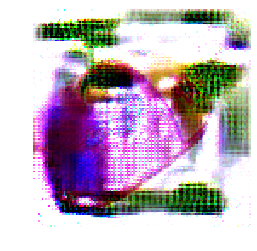

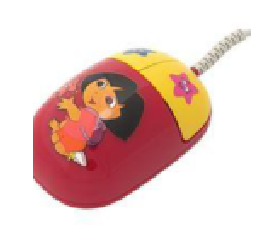

In [0]:
for step in range(100):
    net.eval()
    net.zero_grad()
    input_img = Variable(prep_img_unsqueeze, requires_grad=True).to(device)
    output = net(input_img)
    (-output[0, target]).backward()
    prep_img_unsqueeze = prep_img_unsqueeze - 10*input_img.grad

show_image(prep_img_unsqueeze.cpu().squeeze())
show_image(im.to('cpu'))

In [0]:
print((im - prep_img_unsqueeze.squeeze()).mean())

tensor(0.0012, device='cuda:0')
